# Clustering and Data Visualization

In [37]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import csv

import matplotlib.pyplot as plt
import seaborn

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from itertools import cycle
import pylab as pl

print(__doc__)

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline

Automatically created module for IPython interactive environment


### Combining Data Frames and Cleaning

In [3]:
topicdf = pd.read_pickle("./topic_vectors.pkl")
sentimentdf = pd.read_pickle('./custdf_with_sentiment.pkl')
missing_indices = pd.read_pickle("./missing_indices.pkl")

In [5]:
topicdf = topicdf.reset_index()
missing_idx = missing_indices[0].tolist()

for i in reversed(missing_idx):
    topicdf.drop([i], inplace=True)

In [6]:
df = pd.merge(topicdf, sentimentdf, left_index=True, right_index=True)

del df['index']
del df['tweet_ids_y']

order = ['text', 'company', 'component_1', 'component_2', 'component_3', 'component_4', 'component_5', 'tweet_ids_x', 'compound', 'pos', 'neg', 'neu']

df = df[order]

In [7]:
df = df.rename(columns={'component_1': 'phone_topic', 'component_2': 'attention_topic', 'component_3': 'gaming_topic',
                       'component_4': 'travel_topic', 'component_5': 'deliveries_topic', 'tweet_ids_x': 'tweet_ids'})

In [8]:
df.head()

,text,company,phone_topic,attention_topic,gaming_topic,travel_topic,deliveries_topic,tweet_ids,compound,pos,neg,neu
0,and how do you propose we do that I have se...,sprintcare,0.04924,0.02060,0.00000,0.00000,0.00621,1 2 3 4 5 6 7 8 9 10,-0.7430,0.000,0.156,0.844
1,You gonna magically change your connectivity...,sprintcare,0.04599,0.00000,0.01302,0.00565,0.00000,11 12 13 14 15 16 17 18,-0.6908,0.000,0.147,0.853
2,"whenever I contact customer support, they te...",sprintcare,0.00910,0.00000,0.00071,0.00000,0.01763,19 20,0.2144,0.085,0.000,0.915
3,Would you like me to email you a copy of one...,Ask_Spectrum,0.02668,0.00000,0.00000,0.00098,0.05112,21 22 23 24 25 28 26 29 27,0.4871,0.079,0.034,0.888
4,"Yo , your customer service reps are super nic...",Ask_Spectrum,0.01093,0.00013,0.00305,0.00381,0.00000,30 31,0.4102,0.132,0.000,0.868


### Topic Breakdowns By Company

In [19]:
company_group = df.groupby('company')
topic_by_company = company_group.agg({'phone_topic': 'sum', 'attention_topic': 'sum', 'gaming_topic': 'sum', 'travel_topic': 'sum', 'deliveries_topic': 'sum'})

In [21]:
topic_by_company['totals'] = topic_by_company['phone_topic'] + topic_by_company['attention_topic'] + topic_by_company['gaming_topic'] + topic_by_company['travel_topic'] + topic_by_company['deliveries_topic']

topic_by_company['phone_topic'] = topic_by_company['phone_topic'] / topic_by_company['totals']
topic_by_company['attention_topic'] = topic_by_company['attention_topic'] / topic_by_company['totals']
topic_by_company['gaming_topic'] = topic_by_company['gaming_topic'] / topic_by_company['totals']
topic_by_company['travel_topic'] = topic_by_company['travel_topic'] / topic_by_company['totals']
topic_by_company['deliveries_topic'] = topic_by_company['deliveries_topic'] / topic_by_company['totals']

In [22]:
topic_by_company.reset_index(inplace=True)

topic_by_company.to_csv("company_topics.csv")

topics = topic_by_company.drop(['totals'], axis=1)

In [23]:
X = topics.drop(['company'], axis=1)
X_matrix = X.values

### DBSCAN

In [29]:
clustering = DBSCAN(eps=0.1, min_samples=2).fit(X_matrix)

core_samples = clustering.core_sample_indices_
labels = clustering.labels_

clustering

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=None, p=None)

In [30]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

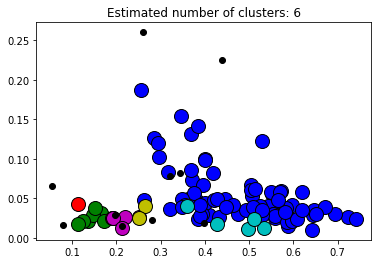

In [32]:
pl.close('all')
pl.figure(1)
pl.clf()

colors = cycle('bgrcmybgrcmybgrcmybgrcmy')

for k, col in zip(set(labels), colors):
    if k == -1:
        col = 'k'
        markersize = 6
        
    class_members = [index[0] for index in np.argwhere(labels == k)]
    cluster_core_samples = [index for index in core_samples if labels[index] == k]
    
    for index in class_members:
        x = X_matrix[index]
        if index in core_samples and k != -1:
            markersize = 14
        else:
            markersize = 6
        pl.plot(x[0], x[1], 'o', markerfacecolor=col,
                markeredgecolor='k', markersize=markersize)

pl.title('Estimated number of clusters: %d' % n_clusters_)
pl.show()

### Dimensionality Reduction with PCA

In [33]:
pca = PCA(n_components=3)
pca.fit(X_matrix)
pcafeatures = pca.transform(X_matrix)

In [34]:
plotdf = pd.DataFrame({'x': pcafeatures[:,0], 'y': pcafeatures[:,1], 'z': pcafeatures[:,2]})

In [35]:
plotdf['company'] = topics['company']
plotdf['labels'] = labels

In [36]:
plotdf.head()

,x,y,z,company,labels
0,-0.135983,-0.096292,-0.028636,ATT,0
1,0.082542,0.576227,-0.415859,ATVIAssist,-1
2,-0.036516,0.158264,0.134678,AWSSupport,0
3,-0.053503,0.146692,-0.061112,AdobeCare,0
4,0.669509,-0.017477,0.089116,AirAsiaSupport,-1


### Plotly 3D Cluster Visualization

In [41]:
df0 = plotdf[plotdf.labels == 0]
x, y, z = df0['x'], df0['y'], df0['z']
trace0 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    name='Retail',
    text=df0.company,
    hoverinfo='text',
    mode='markers',
    marker=dict(
        size=5,
        color='rgba(255, 0, 0)',
        opacity=0.5
    )
)

df1 = plotdf[plotdf.labels== 1]
x1, y1, z1 = df1['x'], df1['y'], df1['z']
trace1 = go.Scatter3d(
    x=x1,
    y=y1,
    z=z1,
    name='Airlines',
    text=df1.company,
    hoverinfo='text',
    mode='markers',
    marker=dict(
        size=5,
        color='blue',
        opacity=0.5
    )
)

df2 = plotdf[plotdf.labels== -1]
x2, y2, z2 = df2['x'], df2['y'], df2['z']
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    name='Online/Gaming',
    text=df2.company,
    hoverinfo='text',
    mode='markers',
    marker=dict(
        size=5,
        color='rgba(0, 0, 255)',
        opacity=0.5
    )
)

df3 = plotdf[plotdf.labels== 2]
x3, y3, z3 = df3['x'], df3['y'], df3['z']
trace3 = go.Scatter3d(
    x=x3,
    y=y3,
    z=z3,
    name='Delivery Services',
    text=df3.company,
    hoverinfo='text',
    mode='markers',
    marker=dict(
        size=5,
        color='rgba(127, 255, 0)',
        opacity=0.5
    )
)

df4 = plotdf[plotdf.labels== 3]
x4, y4, z4 = df4['x'], df4['y'], df4['z']
trace4 = go.Scatter3d(
    x=x4,
    y=y4,
    z=z4,
    name='Tech/Streaming',
    text=df4.company,
    hoverinfo='text',
    mode='markers',
    marker=dict(
        size=5,
        color='rgba(127, 0, 255)',
        opacity=0.5
    )
)

df5 = plotdf[plotdf.labels== 4]
x5, y5, z5 = df5['x'], df5['y'], df5['z']
trace5 = go.Scatter3d(
    x=x5,
    y=y5,
    z=z5,
    name='Trains',
    text=df5.company,
    hoverinfo='text',
    mode='markers',
    marker=dict(
        size=5,
        color='rgba(0, 127, 225)',
        opacity=0.5
    )
)

df6 = plotdf[plotdf.labels== 5]
x6, y6, z6 = df6['x'], df6['y'], df6['z']
trace6 = go.Scatter3d(
    x=x6,
    y=y6,
    z=z6,
    name='Computers',
    text=df6.company,
    hoverinfo='text',
    mode='markers',
    marker=dict(
        size=5,
        color='rgba(127, 127, 255)',
        opacity=0.5
    )
)

data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
offline.plot(fig)

'file:///Users/kari/ds/metis/metisgh/fletcher/temp-plot.html'

#### Below is a still of the 3D PCA plot colored by the DBSCAN clustering:

<img src="legend.png" alt="Drawing" style="float: right; width: 150px;"/> <img src="clusters.png" alt="Drawing" style="float: left; width: 800px;"/>